In [46]:
import sys
import os 
sys.path.append('../src')

import warnings
warnings.filterwarnings('ignore')

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

* Abaixo são criadas as funções que vão nos ajudar nos processos de modelagem e ajuste dos dados.

In [48]:
from statsmodels.tsa.stattools import pacf

def get_lag_features(df, prefixo, target):
    return [col for col in df.columns if col.startswith(prefixo) and col != target]


def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
   
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    return significantLags


def getQlTransformation(x=None, bins=2):
    q = []; I = []; categories = list(range(bins))
    lower = x.min()
    quantile = 1 / bins
    cum = quantile
    ql_x = pd.Series(index=x.index, dtype="Int64")  # Garante dtype correto para evitar NaN
    i = 0

    while cum < 1:
        upper = x.quantile(cum)
        ql_x[(x >= lower) & (x < upper)] = categories[i]
        I.append((lower, upper))
        q.append(upper)
        lower = upper
        cum += quantile
        i += 1

    # Último intervalo (para garantir que o maior valor seja incluído)
    ql_x[x >= lower] = categories[-1]
    I.append((lower, x.max()))
    
    return {'ql_x': ql_x, 'I': I, 'bins': bins, 'categories': categories, 'quantile': quantile}

from pgmpy.inference import VariableElimination

def getEvidence(df, X_qualitative, index):
    index_real = df.index[index]  # Obtém a chave real do índice temporal
    qualitativeRow = df.loc[index_real, X_qualitative]  

    return {'qualitative': qualitativeRow.to_dict()}

def predict(y_qualitative, df, modelInfer,X_qualitative, qlTrans):
    preds = pd.DataFrame(index=df.index)
    preds['~Valor_ql'] = pd.Series(index=df.index, dtype=object)

    for i in range(df.shape[0]):
        ev_i = getEvidence(df,X_qualitative, i)
        
        # Usa as chaves corretas ('qualitative' e 'quantitative')
        dist_i = modelInfer.query([y_qualitative], evidence=ev_i['qualitative'])

        # Encontra o índice da maior probabilidade corretamente
        index = np.argmax(dist_i.values)

        # Obtém a predição qualitativa
        qlPred_i = dist_i.state_names[y_qualitative][index]
        preds.loc[df.index[i], '~Valor_ql'] = qlPred_i

    return preds

# Contextualização

Nos últimos anos, a oscilação nos preços da gasolina tornou-se um dos problemas mais debatidos no Brasil, especialmente devido à volatilidade acentuada a partir de 2020. Em março daquele ano, o litro de gasolina custava, em média, R$ 4,598, e no intervalo de 12 meses apresentou uma alta de 27,26%. Entre 2020 e 2022, o preço da gasolina aumentou cerca de 2,6 vezes mais que a inflação acumulada, medida pelo IPCA, que foi de 21,86% no período, segundo o IBGE. Desde então, os preços têm variado semanalmente, alcançando R$ 7,99 em alguns postos no ano de 2024, conforme dados da ANP.

Para esta análise, foram considerados os anos de 2019 a 2024, um período marcado por intensas flutuações nos preços dos combustíveis. Essas oscilações foram influenciadas por uma combinação de fatores, incluindo as consequências econômicas da pandemia de COVID-19, que afetaram a produção e o consumo global; variações na cotação do dólar, dado que o Brasil depende de importações para parte de seu consumo de combustíveis; mudanças nas políticas de precificação da Petrobras, que ajusta os preços de acordo com o mercado internacional; além de flutuações no preço do petróleo no mercado global e eventos geopolíticos que impactaram o suprimento e a demanda por combustíveis.

Essa acentuada variação nos preços tornou a previsão de valores um desafio significativo. Esse tema tem despertado grande interesse tanto na academia quanto no setor privado, que buscam soluções para compreender e prever as mudanças no mercado de combustíveis. Apesar dos avanços recentes nos métodos de previsão, muitos modelos ainda enfrentam dificuldades para capturar com precisão tanto a volatilidade dos preços semanais quanto as tendências de longo prazo, o que reforça a necessidade de pesquisas contínuas e o desenvolvimento de ferramentas mais robustas para análise desse mercado.


# Pré-processamento

## 2.1. Leitura  e análise dos dados

Ao analisar as séries temporais dos preços da gasolina, podemos observá-los em quatro momentos principais:

Período anterior a 2020: Antes de 2020, os preços da gasolina apresentavam uma variação moderada. Embora houvesse uma leve subida seguida de uma queda, os preços raramente ultrapassavam a marca de 5 reais. Na maior parte das cidades, o preço se manteve dentro de um intervalo relativamente estável, sem grandes flutuações. A exceção notável foi Salvador, onde o preço da gasolina permaneceu praticamente constante durante esse período, sem grandes variações, o que pode estar relacionado à dinâmica local do mercado de combustíveis e políticas regionais.

Início da pandemia de COVID-19 (2020): Com o advento da pandemia de COVID-19 no início de 2020, o cenário econômico mundial sofreu uma forte mudança. Nos primeiros meses do ano, os preços da gasolina caíram, reflexo da queda na demanda global de combustíveis devido ao isolamento social e à paralisação de diversas atividades econômicas. No entanto, logo após essa queda inicial, o preço começou a aumentar de forma significativa. Esse aumento foi impulsionado pela crise econômica global provocada pela pandemia, que afetou o mercado de petróleo e combustíveis, além de desajustes nas cadeias de fornecimento. O impacto da pandemia causou uma elevação generalizada dos preços da gasolina em diversas partes do mundo, incluindo o Brasil, onde o mercado local foi afetado pela instabilidade econômica.

Após 2022 – Queda e recuperação (2022): Em 2022, a situação econômica no Brasil e no mundo começou a se estabilizar parcialmente. Os preços da gasolina passaram a se manter mais constantes por algumas semanas, mas logo em seguida iniciaram uma nova tendência de crescimento. Essa variação foi diretamente influenciada por fatores como a recuperação econômica global pós-pandemia, o aumento da demanda por combustíveis à medida que a economia voltava ao normal e as flutuações nos preços do petróleo no mercado internacional. No entanto, o grande evento que afetou fortemente os preços foi a eleição presidencial no Brasil no final de 2022. Durante esse período, a política interna teve um papel importante na regulação dos preços dos combustíveis. O governo que estava saindo adotou políticas de redução de impostos sobre combustíveis para tentar aliviar o impacto da alta dos preços, o que resultou em uma queda significativa nos preços no final de 2022. Essa mudança foi vista como uma tentativa de controlar a inflação e conquistar apoio popular em um momento de grande tensão política e social.

Início de 2023 – Mudanças políticas e novo padrão de preços (2023): O início de 2023 foi marcado pela posse de um novo presidente no Brasil, o que trouxe novas diretrizes econômicas e políticas para o país. Nesse período, os preços da gasolina voltaram a subir, impulsionados principalmente por ajustes nas políticas de preços dos combustíveis e pela adaptação do mercado a um novo cenário econômico. O novo governo adotou uma série de medidas que afetaram diretamente o mercado de combustíveis, incluindo a revisão da política de subsídios e o controle da inflação. Apesar disso, os preços se estabilizaram em torno de 5 a 6 reais em muitas cidades, embora algumas localidades, como Fortaleza e Natal, registrassem valores mais altos devido a fatores regionais e à oferta local de combustíveis. A política fiscal e a postura do novo governo em relação ao setor energético continuaram a influenciar a dinâmica de preços durante esse período, com tentativas de equilibrar o custo para o consumidor e a sustentabilidade das finanças públicas.

Conclusão: O preço da gasolina no Brasil, assim como em outros países, é influenciado por uma complexa interação de fatores econômicos, políticos e sociais. A análise das séries temporais revela que, ao longo dos últimos anos, essas variáveis exerceram um impacto significativo nas flutuações de preços.

Primeiramente, fatores econômicos globais, como a pandemia de COVID-19, desempenharam um papel crucial, provocando quedas iniciais seguidas de aumentos expressivos nos preços da gasolina. A crise sanitária gerou uma desestabilização das cadeias de fornecimento, elevando os custos dos combustíveis, enquanto a recuperação econômica trouxe uma nova pressão sobre os preços. No Brasil, a política interna também teve grande peso, especialmente em momentos de incerteza política, como nas eleições de 2022, quando mudanças nas políticas fiscais, como a redução de impostos sobre combustíveis, resultaram em uma queda temporária no preço.

Além disso, o impacto de decisões políticas no setor energético, especialmente com a troca de governos, revelou-se fundamental para moldar o comportamento dos preços nos anos seguintes. O novo governo de 2023, ao adotar medidas voltadas ao controle da inflação e à gestão da política de preços dos combustíveis, teve uma influência direta no aumento gradual dos preços, com algumas regiões, como Fortaleza e Natal, mostrando variações ainda mais pronunciadas.

Portanto, o preço da gasolina é resultado de uma confluência de fatores globais, nacionais e regionais, com o mercado de combustíveis sendo sensível a mudanças econômicas externas, como o valor do petróleo, e a decisões políticas internas, que buscam equilibrar interesses econômicos e sociais. A compreensão desses múltiplos impactos é essencial para analisar o comportamento dos preços e suas variações ao longo do tempo, evidenciando a complexidade desse mercado e a necessidade de políticas públicas que considerem tanto os desafios econômicos globais quanto as realidades locais.

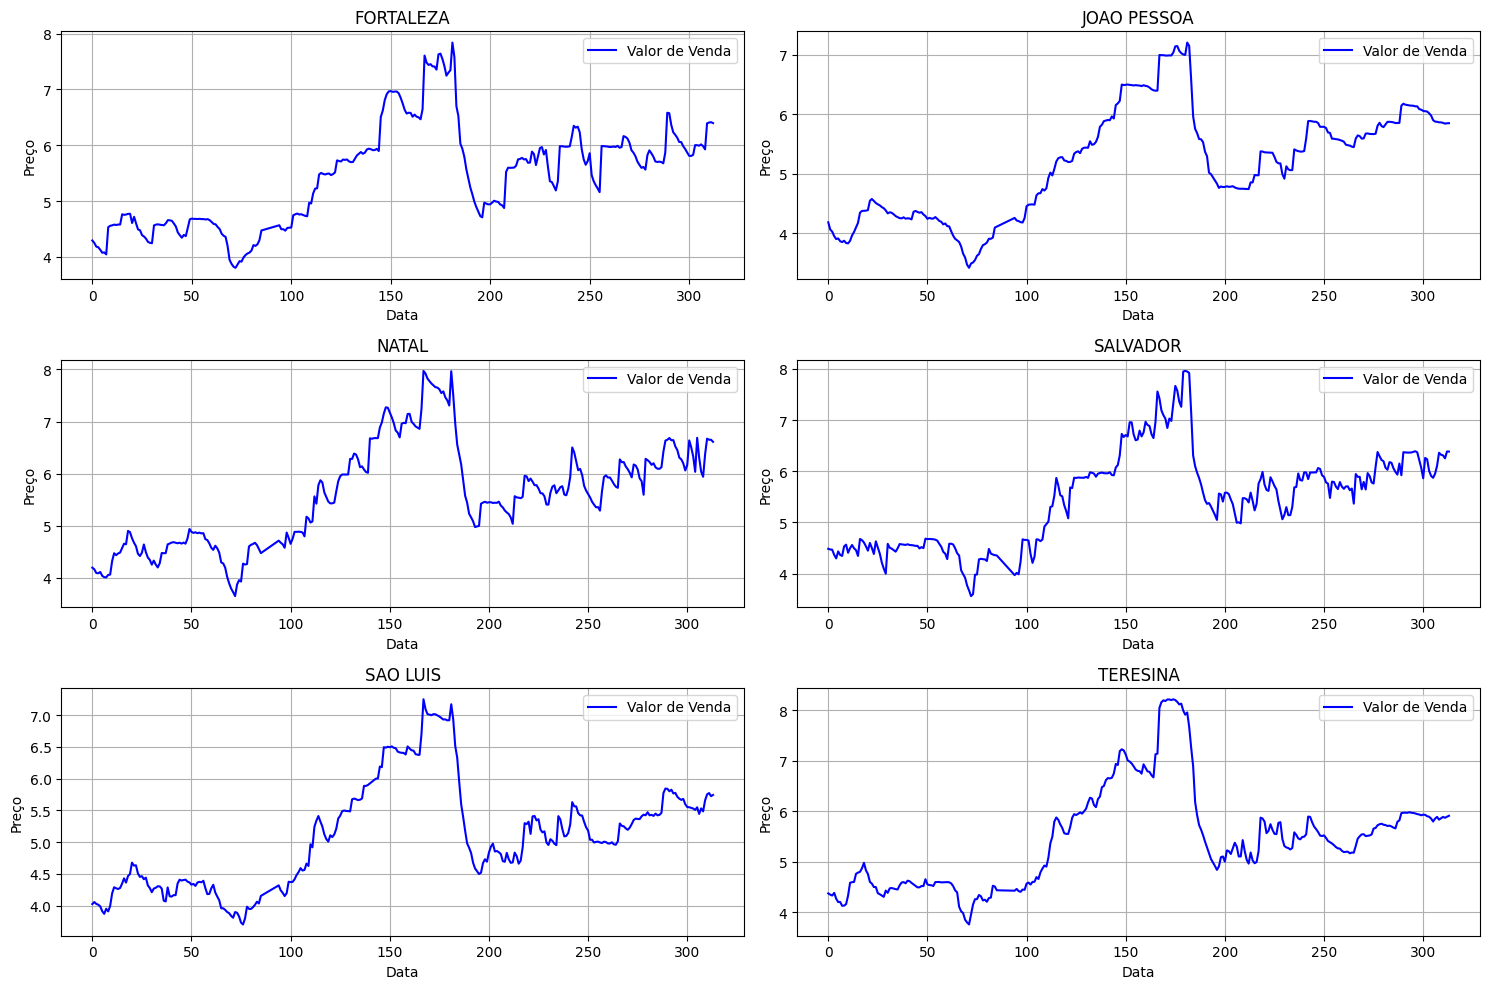

In [49]:
# Diretório de entrada
input_dir = "../data/Gold"

# Listar arquivos CSV na pasta Gold
files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

# Dicionário para armazenar os DataFrames
data_frames = {}

# Configuração da grade de plots
rows, cols = 3, 2  # Layout 3x2
num_plots = len(files)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # Facilita o acesso aos subplots

for i, file in enumerate(files):
    file_path = os.path.join(input_dir, file)
    
    # Carregar dados
    data = pd.read_csv(file_path, delimiter=',') 
    
    # Salvar o DataFrame no dicionário com nome da série
    serie_name = file.replace(".csv", "")
    data_frames[serie_name] = data  # Armazenando o DataFrame no dicionário
    
    # Plot no subplot correspondente
    axes[i].plot(data['Valor_de_Venda'], color='blue', label='Valor de Venda')
    axes[i].set_title(file.replace(".csv", ""))
    axes[i].set_xlabel('Data')
    axes[i].set_ylabel('Preço')
    axes[i].grid(True)
    axes[i].legend()

# Remover eixos vazios se não preencher toda a grade
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##  2.3. Transformação de variáveis

Para a etapa de aplicação dos modelos é necessário criação/transformação das variaveis preditoras, ou seja, a criação dos valores de lags como preditoras abaixo utilizamos a função ``getSignificantLags`` que utiliza PACF para avaliar os valores de lags mais relevantes.  
Com isso, construimos como variaveis preditoras os valores de venda do preço da gasolina de forma defasada para cada uma das series.

In [50]:
# Número de bins para a discretização
bins = 8 

# Dicionário para armazenar qlTrans de cada cidade
qlTrans_dict = {}

# Loop para cada DataFrame em data_frames
for nome, df in data_frames.items():
    # Aplicar QL discretização
    qlTrans = getQlTransformation(x=df['Valor_de_Venda'], bins=bins)
    
    # Salvar qlTrans no dicionário para cada cidade
    qlTrans_dict[nome] = qlTrans
    
    # Adicionar a coluna 'Valor_ql' ao DataFrame com a transformação qualitativa
    df['Valor_ql'] = qlTrans['ql_x']
    
    # Calcular lags significativos
    significant_lags_discrete = getSignificantLags(df['Valor_ql'], nLags=7, alpha=0.05)

    print(f"Para {nome}:")
    print('Lag discrete value:', significant_lags_discrete)

    # Criar lags relevantes
    for lag in significant_lags_discrete:
        df[f'Valor_ql_lag{lag}'] = df['Valor_ql'].shift(lag)
        
    # Remover linhas com NaNs geradas pelos lags
    df.dropna(inplace=True)
    
    # Dropar os últimos max(lags) valores para manter consistência
    if significant_lags_discrete:
        df = df.iloc[:-max(significant_lags_discrete)]
    
    # Atualizar no dicionário
    data_frames[nome] = df



Para FORTALEZA:
Lag discrete value: [1]
Para JOAO PESSOA:
Lag discrete value: [1, 4]
Para NATAL:
Lag discrete value: [1]
Para SALVADOR:
Lag discrete value: [1, 2, 3]
Para SAO LUIS:
Lag discrete value: [1, 5]
Para TERESINA:
Lag discrete value: [1]


Também é necessário fazer alguns ajustes nos dados.  
Abaixo ajustamos a coluna de data convertendo em valores ``datetime`` e tambem definimos ela como index dos dataframes, além disso também é feito o drop da coluna `Produto` pois trabalharemo somente com o preço da gasolina e também dropamos a coluna `Valor_de_venda` pois nesse notebook usaremos somente valores qualitativos.

In [51]:
# Para cada DataFrame no dicionário 'data_frames'
for nome, df in data_frames.items():
    # Converter a coluna 'Data da Coleta' para datetime
    df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'])
    
    # Definir 'Data da Coleta' como o índice do DataFrame
    df.set_index('Data da Coleta', inplace=True)
    df.drop(columns=['Produto','Valor_de_Venda'], inplace=True)  # Remover a coluna 'Valor_ql' se necessário
    # Atualizar no dicionário
    data_frames[nome] = df

##  2.4. Partição dos dados de treinamento entre treino e validação

A seguir fazemos as etapas de particionar os dados em treinamento,teste e validação. Esta etapa é crucial para avaliar os desempenhos dos modelos propostos.  
* Para isso dividimos o conjunto de dados da seguinte maneira:
    * O treinamento é composto por todos os dados, exceto as 10 ultimas observações da série.
    * O teste é composto pelas primeiras 5 observações após o treinamento.
    * A validação é composta pelas primeiras 5 observações após o teste.  

Com isso, temos as partições da forma exata para treinar e avaliar como esta o modelo ate mais de um mês no futuro que são os 5 valores para treinamento e teste.  

In [52]:
train_data_dict = {}
val_data_dict = {}
test_data_dict = {}

for nome, df in data_frames.items():
    train_data = df.iloc[:-10]     # Todas menos as 20 últimas
    val_data = df.iloc[-10:-5]    # Da posição -20 até -10 (validação)
    test_data = df.iloc[-5:]      # As últimas 10 linhas (teste)

    train_data_dict[nome] = train_data
    val_data_dict[nome] = val_data
    test_data_dict[nome] = test_data


# Modelagem

Nas seções abaixo trabalhamos com a modelagem dos dados, aplicando tanto modelos manualmente definidos quanto modelos otimamente definidos.  
Os modelos aplicados se dividem em duas seções modelos bayesianos usando a estatistica bayesiana, e os modelos da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.

## 3.1. Modelos manualmente definidos

Abaixo trazemos os modelos manualmente definidos, estes modelos tem os parâmetros definidos de forma manual, estes modelos tendem a ter menor desempenho pois modelos com parâmetros definidos manualmente tendem a ser menos robustos e ter um pior desempenho.

### 3.1.1. Modelo bayesiano

Nesta seção abordamos o modelo bayesiano usando a biblioteca `pgmpy`.  
O `pgmpy` é uma biblioteca Python para modelagem de Redes Bayesianas, que são modelos gráficos probabilísticos representando dependências condicionais entre variáveis aleatórias, este modelo é um modelo supervisionado que usa probabilidades condicionais para prever uma variável alvo (classe).


A ideia central é aplicar o Teorema de Bayes para inferir a probabilidade da classe com base nas evidências (variáveis preditoras).

No código abaixo ajustamos as variáveis do conjunto de treinamento para estrutramos na forma de um grafo, ou seja, com vértices e arestas que ligam as variáveis, estas etapas são necessárias para usar o modelo bayesiano da biblioteca `pgmpy`.

In [53]:
graph_dict = {}
X_qualitative_dict = {}

y_qualitative = 'Valor_ql'


for nome, train_data in train_data_dict.items():
    graph = []

    X_qualitative = get_lag_features(train_data, 'Valor_ql_', y_qualitative)

        # Armazena essas variáveis nos dicionários
    X_qualitative_dict[nome] = X_qualitative

    for coluna_lag in X_qualitative:
        graph.append((coluna_lag, y_qualitative))

    graph_dict[nome] = graph


Abaixo é feita a criação do modelo bayesiano usando o grafo criado anteriormente, o modelo é criado e treinado para cada uma das series.  
O metodo de inferencia é o metodo `VariableElimination`.


O método de inferência `VariableElimination` (Eliminação de Variáveis) é um algoritmo exato e clássico usado em inferência probabilística em redes bayesianas (ou redes de crença). Ele é usado para calcular probabilidades marginais ou condicionais de variáveis de interesse, dado um conjunto de evidências.


* 🎯 Objetivo

O objetivo é calcular, por exemplo:

$
P(X \mid E = e)
$
onde:

- $ X $ é a variável (ou conjunto de variáveis) de interesse.
- $ E = e $ é um conjunto de evidências observadas.

Para fazer isso, o algoritmo elimina (ou **marginaliza**) as variáveis **não observadas** e **não de interesse** do modelo, uma por uma, usando **soma marginal** (ou produto, se for fator de probabilidade condicional).

---

* 🧠 Etapas do algoritmo

    * **Fatores iniciais**  
    Começa com os fatores da rede — geralmente tabelas de probabilidade condicional (CPTs).

    * **Incorporação da evidência**  
    As variáveis evidenciadas (como \( E = e \)) são inseridas nos fatores, reduzindo-os.

    * **Eliminação das variáveis ocultas**  
    Para cada variável que não está no conjunto de evidência nem é a variável alvo, o algoritmo:
    
    - Multiplica todos os fatores que a contêm.
    - Marginaliza (soma) sobre essa variável, criando um novo fator.
    - Substitui os antigos fatores pelo novo.

    * **Resultado final**  
    Ao final, os fatores restantes são multiplicados, e o resultado é **normalizado** (se necessário) para obter uma **distribuição de probabilidade**.

---


In [54]:
from pgmpy.models import DiscreteBayesianNetwork 
from pgmpy.estimators import BayesianEstimator

# Criando os modelos e armazenando em dicionários
bayesian_models = {}
bayesian_inferences = {}

y_qualitative = 'Valor_ql'

for nome, train_data in train_data_dict.items():

    # Criar o grafo da rede bayesiana (somente com variáveis qualitativas)
    graph = []

    # Adicionar variáveis qualitativas ao gráfico
    X_qualitative_data = X_qualitative_dict[nome]  # Obtém as variáveis qualitativas para esse município
    for coluna_lag in X_qualitative_data:
        # Conectando cada variável de lag qualitativa ao target
        graph.append((coluna_lag, y_qualitative))

    # Criar o modelo de Rede Bayesian apenas com variáveis qualitativas
    beModel = DiscreteBayesianNetwork(graph)
    
    # Estimar o modelo com o BayesianEstimator
    beModel.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=3 * bins)
    
    # Realizar inferência com a variável de eliminação
    beInfer = VariableElimination(beModel)
    
    # Verificar o modelo
    model_check = beModel.check_model()
    
    # Armazenar os resultados
    bayesian_models[nome] = beModel
    bayesian_inferences[nome] = beInfer




INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag4': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag2': 'N', 'Valor_ql_lag3': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N', 'Valor_ql_lag5': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Valor_ql': 'N', 'Valor_ql_lag1': 'N'}


Abaixmo mostramos os grafos do modelo bayesiano, com isso podemos ver quais variáveis e lags influenciam na variável target.

Renderizando grafo para: FORTALEZA


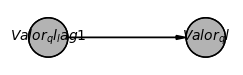

Renderizando grafo para: JOAO PESSOA


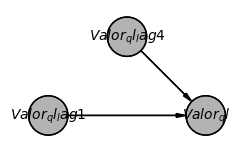

Renderizando grafo para: NATAL


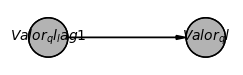

Renderizando grafo para: SALVADOR


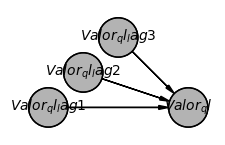

Renderizando grafo para: SAO LUIS


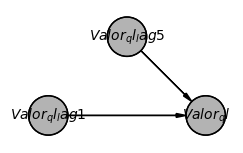

Renderizando grafo para: TERESINA


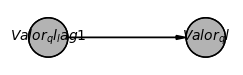

In [55]:
import matplotlib.pyplot as plt

# Iterar sobre todos os modelos no dicionário
for nome, modelo in bayesian_models.items():
    print(f"Renderizando grafo para: {nome}")

    try:
        # Criar o gráfico Daft
        daft_graph = modelo.to_daft(node_pos='planar', latex=True)

        # Renderizar o gráfico
        daft_graph.render()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao renderizar o grafo para {nome}: {e}")


Abaixo é feita as predições utilizando o modelo criado anteriormente e as variáveis qualitativas de lags que foram definidas anteriormente.

A função `predict`é chamada para realizar previsões nos conjuntos de dados de teste, com o modelo `beInfer` (inferência Bayesiana) e a tabela de transformação `qlTrans` que mapeia as variáveis qualitativas.  
O resultado da função `predict` é armazenado em um diciónario que armazena as predições para cada uma das cidades.  

In [56]:
predict_test_dict = {}

for nome, df in test_data_dict.items():
    '''predics_test = predict(y_qualitative='Valor_ql',
                        df=df,
                        modelInfer=bayesian_inferences[nome],
                        X_qualitative=X_qualitative_dict[nome],
                        qlTrans=qlTrans_dict[nome])
    '''
    model = bayesian_models[nome]
    df = test_data_dict[nome]
    predict_test_dict[nome] =  predict(y_qualitative='Valor_ql',
                        df=df,
                        modelInfer=bayesian_inferences[nome],
                        X_qualitative=X_qualitative_dict[nome],
                        qlTrans=qlTrans_dict[nome])




Abaixo é criado o dicionário que armazena as métricas de erro para cada série utilizada no modelo de inferência bayesiana.

In [57]:
from sklearn.metrics import log_loss, mean_absolute_error

results_bayes_inference = []

for nome, predics_test in predict_test_dict.items():
    y_true = test_data_dict[nome]['Valor_ql']
    y_pred = predics_test['~Valor_ql']  # classes previstas

    # Acurácia (baseada em erro absoluto médio)
    acuracia = 1 - abs(y_true - y_pred).mean()

    # MAE
    mae = mean_absolute_error(y_true, y_pred)

    results_bayes_inference.append({
        'Cidade': nome,
        'Modelo': 'Bayes Inference',
        'Acurácia': acuracia,
        'MAE': mae
    })

# DataFrame com os resultados
results_bayes_inference_df = pd.DataFrame(results_bayes_inference)


### Modelos sklearn

Abaixo são criados os modelos manualmente definidos da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.  
Todos os modelos abaixo tem os parâmetros definidos de forma manual, buscando trazer o melhor desempenho e robustez para o modelo.

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

models_with_params_manual = {

    'Logistic Regression': LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000
    ),

    'Random Forest Classifier': RandomForestClassifier(
        n_estimators=150,
        max_depth=10,
        criterion='gini',
        random_state=42
    ),

    'XGBoost Classifier': XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.05,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),

    'Support Vector Machine': SVC(
        C=1.0,
        kernel='rbf',
        gamma='scale'
    )

}

No codigo abaixo é feita as predições dos dados de teste para cada cidade utilizando os modelos definidos anteriormente.   
Nesta etapa fazemos as predições dos dados e o calculo das metricas de erro para cada cidade, salvando tudo em um dataframe para ser análisado em outra seção.

In [59]:
from sklearn.metrics import accuracy_score

# Armazenar resultados para todas as séries
all_results = []

# Armazenar melhor modelo por série
best_models_dict = {}

# Loop por cada série temporal (ou município)
for nome in train_data_dict.keys():
    train_data = train_data_dict[nome]
    test_data = test_data_dict[nome]

    y_train = train_data['Valor_ql']
    y_test = test_data['Valor_ql']
    X_train = train_data.drop(columns=['Valor_ql'])
    X_test = test_data.drop(columns=['Valor_ql'])

    best_accuracy = float('-inf')
    superior_model = None
    superior_model_name = None

    # Loop por cada modelo com parâmetros fixos
    for name, model in models_with_params_manual.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        mae = mean_absolute_error(y_true, y_pred)

        all_results.append({
            'Cidade': nome,
            'Modelo': name,
            'Acurácia': accuracy,
            'MAE': mae
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_MAE = mae
            superior_model = model
            superior_model_name = name

    # Salva o melhor modelo dessa série
    best_models_dict[nome] = {
        'modelo': superior_model,
        'nome_modelo': superior_model_name,
        'acuracia': best_accuracy,
        'MAE': best_MAE
    }

# DataFrame com os resultados de todos os modelos testados
all_results_df = pd.DataFrame(all_results)

# DataFrame com o melhor modelo de cada município
melhores_resultados = []

for cidade, info in best_models_dict.items():
    melhores_resultados.append({
        'Cidade': cidade,
        'Modelo': info['nome_modelo'],
        'Acurácia': info['acuracia'],
        'MAE': info['MAE']
    })

melhores_modelos_df = pd.DataFrame(melhores_resultados)


No código abaixo é feita concatenação dos dataframes de resultados do modelo bayesiano e do resultado dos modelos da `scikit-learn` dessa forma a análise feita na seção de **Medidas de desempenho** será possivel discutir a cerca de todos os modelos que foram definidas manualmente.

In [60]:
df_combined_ManParam = pd.concat([results_bayes_inference_df, all_results_df], ignore_index=True)

df_combined_ManParam = df_combined_ManParam.dropna(subset=['Cidade', 'Modelo', 'Acurácia','MAE'])

## 3.2. Modelos otimamente definidos

Modelos otimizados utilizam estratégias sistemáticas de busca — como validação cruzada, otimização bayesiana ou algoritmos evolutivos — para selecionar automaticamente a melhor combinação de hiperparâmetros. Esse processo visa maximizar métricas de desempenho específicas, reduzindo a subjetividade e o viés inerentes à definição manual. Em comparação com modelos ajustados empiricamente, os modelos otimizados tendem a apresentar maior generalização e desempenho superior nos dados de teste, uma vez que exploram de forma mais abrangente o espaço de configuração do modelo.

### 3.2.1. Modelo bayesiano com simulação

Para otimizar o modelo bayesiano usamos um modelo com simulação usando a biblioteca `PyMC` traga uma explicação sobre simulação e  sobre a biblioteca `PyMC`.
Em estatística bayesiana, simulação se refere ao uso de métodos computacionais para aproximar distribuições posteriores de parâmetros, quando não é possível obtê-las de forma analítica. Isso é especialmente necessário em modelos complexos ou hierárquicos, nos quais a posterior não possui forma fechada.


A inferência por simulação usando o `PyMC` pode ser mais vantajosa do que os métodos tradicionais de inferência exata, como o VariableElimination da biblioteca `pgmpy`, especialmente em contextos mais complexos. Enquanto o `pgmpy` é eficaz para redes discretas e de pequena escala, onde as distribuições de probabilidade podem ser manipuladas diretamente por meio de tabelas e operações analíticas, ele apresenta limitações quando lidamos com modelos maiores, contínuos ou hierárquicos. O `PyMC`, por outro lado, permite que os parâmetros do modelo sejam tratados como variáveis aleatórias com distribuições a priori, possibilitando a construção de modelos bayesianos completos e flexíveis. Utilizando técnicas como *MCMC* (Markov Chain Monte Carlo), o `PyMC` simula amostras da distribuição posterior, o que permite estimar não apenas valores pontuais, mas também intervalos de credibilidade que capturam a incerteza da inferência. Além disso, sua capacidade de modelar relações não-lineares e estruturas hierárquicas torna-o uma ferramenta muito mais poderosa para análise bayesiana em situações onde os métodos exatos, como os do `pgmpy`, tornam-se inviáveis computacionalmente ou incapazes de capturar a complexidade do fenômeno modeladado.

Abaixo importamos a classe onde foi criado os codigo de ``fit()`` e ``predict_proba()`` com a biblioteca `PyMC`. 

O método `fit` é responsável por ajustar um modelo bayesiano de regressão logística multinomial para variáveis categóricas usando a biblioteca PyMC. Nele, os dados são divididos em variáveis preditoras `X` e uma variável resposta `y`, que representa classes discretas. O modelo assume que a probabilidade de cada classe é determinada por uma combinação linear dos preditores com coeficientes específicos para cada classe. Esses coeficientes são representados por distribuições a priori normais (`beta0` para os interceptos e `betas` para os pesos das variáveis), e os logits — combinação linear entre `X` e `betas` acrescida de `beta0` — são usados para parametrizar uma distribuição categórica para a variável observada. A inferência é feita com o método `find_MAP`, que encontra o ponto de máximo da distribuição a posteriori, fornecendo estimativas pontuais para os parâmetros do modelo.

Já o método `predict_proba` utiliza os parâmetros estimados durante o `fit` para fazer predições em novos dados. Primeiro, ele calcula os logits — valores antes da função softmax — como o produto da matriz de preditores `X_new` pelos pesos `betas`, somando o intercepto `beta0`. Em seguida, aplica a função softmax aos logits para converter esses valores em probabilidades associadas a cada classe. O resultado é uma matriz onde cada linha representa uma observação e cada coluna representa a probabilidade da observação pertencer a uma classe específica. A predição final para cada instância é dada pela classe com maior probabilidade, obtida com `np.argmax`, fornecendo uma estimativa categórica a partir de um modelo que foi ajustado para aprender as relações probabilísticas entre variáveis quantitativas e uma resposta qualitativa.


In [61]:
import sys
import os
sys.path.append(os.path.abspath('..')) 

from BayesModel import BayesMapClassifier

Abaixo é usado o método ``fit()`` e ``predict_proba()`` para cada um das séries.

In [62]:
predictions_dict = {}

for nome, df_test in test_data_dict.items():
    print(f"Processando: {nome}")
    MapInference = BayesMapClassifier()
    # Inicializa e treina o modelo
    
    df_train = train_data_dict[nome]
    MapInference.fit(df_train)

    # Previsão em lote
    X_test = df_test.drop(columns=["Valor_ql"])
    y_pred = MapInference.predict_proba(X_test)

    predictions_dict[nome] = y_pred


Processando: FORTALEZA
Processando: JOAO PESSOA
Processando: NATAL
Processando: SALVADOR
Processando: SAO LUIS
Processando: TERESINA


In [63]:
import pandas as pd
from sklearn.metrics import accuracy_score

resultados = []

for nome, y_pred in predictions_dict.items():
    y_true = test_data_dict[nome]['Valor_ql']
    
    acuracia = accuracy_score(y_true, y_pred)
    # MCC
    mae = mean_absolute_error(y_true, y_pred)


    resultados.append({
        "Cidade": nome,
        "Modelo": "BayesInferenceMap",
        "Acurácia": acuracia,
        'MAE': mae
    })

df_resultados = pd.DataFrame(resultados)


### 3.2.2 Modelos sklearn

Abaixo são apresentados os modelos otimizados por meio do *BayesSearchCV*, uma técnica de busca bayesiana que ajusta automaticamente os hiperparâmetros com base em desempenho validado. Essa abordagem busca de forma eficiente as melhores combinações de parâmetros para cada modelo, equilibrando exploração e exploração do espaço de busca, com o objetivo de maximizar a performance preditiva e a robustez dos classificadores. A utilização do *BayesSearchCV* permite encontrar configurações que muitas vezes superam aquelas definidas manualmente, ao considerar interações complexas entre os hiperparâmetros e adaptando-se melhor aos dados do problema. 

Aplicaremos os modelos que já vem sendo usado da scikit-lear como Support Vector Machine, XGBoost Classifier, Random Forest Classifier, Logistic Regression.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from skopt.space import Real, Integer, Categorical

models_with_params = {

    # Modelos de classificação
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'param_grid': {
            'C': Real(0.01, 10, prior='log-uniform'),
            'penalty': Categorical(['l2']),
            'solver': Categorical(['lbfgs'])
        }
    },
    'Random Forest Classifier': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': Integer(100, 200),
            'max_depth': Categorical([None, 10, 30]),
            'criterion': Categorical(['gini', 'entropy', 'log_loss'])
        }
    },
    'XGBoost Classifier': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'param_grid': {
            'n_estimators': Integer(100, 200),
            'max_depth': Integer(3, 10),
            'learning_rate': Real(0.01, 0.1, prior='log-uniform')
        }
    },
    'Support Vector Machine': {
        'model': SVC(),
        'param_grid': {
            'C': Real(0.1, 10.0, prior='log-uniform'),
            'kernel': Categorical(['linear', 'rbf']),
            'gamma': Categorical(['scale', 'auto'])
        }
    },

}


No codigo abaixo é feita as predições dos dados de teste para cada cidade utilizando os modelos otimamente definidos anteriormente.   
Nesta etapa fazemos as predições dos dados e o calculo das metricas de erro para cada um das cidade.  
Após isso, as métricas são salvas em um dataframe para ser análisado em outra seção.

In [65]:
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV


# Armazenar resultados para todas as séries
all_results = []

# Armazenar melhor modelo por série
best_models_dict = {}

# Loop sobre todas as séries (ex: 'FORTALEZA', 'CAUCAIA' etc.)
for nome in train_data_dict.keys():
    train_data = train_data_dict[nome]
    test_data = test_data_dict[nome]

    y_train = train_data['Valor_ql']
    y_test = test_data['Valor_ql']
    X_train = train_data.drop(columns=['Valor_ql'])
    X_test = test_data.drop(columns=['Valor_ql'])

    best_accuracy = float('-inf')
    superior_model = None
    superior_model_name = None

    # Loop para aplicar BayesSearchCV e avaliar modelos
    for name, config in models_with_params.items():
        model = config['model']
        param_space = config['param_grid']

        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_space,
            scoring='accuracy',
            cv=5,
            n_iter=30,
            n_jobs=-1,
            refit=True,
            random_state=42
        )

        bayes_search.fit(X_train, y_train)
        best_model = bayes_search.best_estimator_

        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        mae = mean_absolute_error(y_true, y_pred)

        
        all_results.append({
            'Cidade': nome,
            'Modelo': name,
            'Acurácia': accuracy,
            'MAE': mae
            
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_MAE = mae
            superior_model = best_model
            superior_model_name = name
 
    # Salva o melhor modelo dessa série
    best_models_dict[nome] = {
        'modelo': superior_model,
        'nome_modelo': superior_model_name,
        'acuracia': best_accuracy,
        'MAE': best_MAE
    }

# DataFrame com os resultados
all_results_df = pd.DataFrame(all_results)

# DataFrame com os resultados de todos os m odelos testados
all_results_df = pd.DataFrame(all_results)

# DataFrame com o melhor modelo de cada município
melhores_resultados = []

for cidade, info in best_models_dict.items():
    melhores_resultados.append({
        'Cidade': cidade,
        'Modelo': info['nome_modelo'],
        'Acurácia': info['acuracia'],
        'MAE': info['MAE']
    })

melhores_modelos_df = pd.DataFrame(melhores_resultados)


No código abaixo é feita concatenação dos dataframes de resultados do modelo bayesiano da biblioteca `PyMC` e do resultado dos modelos otimamente definidos da `scikit-learn` dessa forma a análise feita na seção de **Medidas de desempenho** será possivel discutir a cerca de todos os modelos que foram definidas manualmente.

In [66]:
df_combined_HipParam = pd.concat([df_resultados, all_results_df], ignore_index=True)

df_combined_HipParam = df_combined_HipParam.dropna(subset=['Cidade', 'Modelo', 'Acurácia','MAE'])

## 3.3. Medidas de desempenho

*  Acurácia
    - **Definição**: Mede a proporção de previsões corretas em relação ao total de previsões realizadas.
    - **Uso**: É uma métrica simples e intuitiva, útil especialmente quando as classes estão **balanceadas**.
    - **Limitação**: Pode ser **enganosa** em cenários com classes **desbalanceadas**, pois erros em classes minoritárias têm pouco impacto no valor final da acurácia.

* MAE (Mean Absolute Error)
    - **Definição**: Calcula a **média da diferença absoluta** entre os valores reais e os valores previstos.
    - **Uso**: É especialmente apropriada para **classificação ordinal**, onde existe uma **ordem natural entre as classes** (por exemplo, de 0 a 6).
    - **Vantagem**: Penaliza erros **proporcionalmente à distância** entre as classes — errar de 0 para 1 é menos grave do que errar de 0 para 6.


### 3.3.1. Modelos Manualmente definidos

A seguir veremos as medidas de desempenho para os modelos manualmente definidos. 

#### 3.3.1.1. Acurácia

A seguir, observamos a medida de acurácia por cidade. Nota-se que, em algumas localidades, os modelos apresentam melhor desempenho, como é o caso de João Pessoa e Teresina, onde a acurácia atingiu o valor máximo de 1.0, indicando uma adaptação perfeita dos modelos a essas cidades.

Em seguida, destaca-se a cidade de Natal, que obteve a maior acurácia depois de João Pessoa e Teresina.

Por outro lado, cidades como São Luís, Fortaleza e Salvador apresentaram desempenhos inferiores, com acurácia igual ou inferior a 0.6, indicando que os modelos definidos manualmente não conseguiram se adaptar com a mesma eficácia nessas localidades.

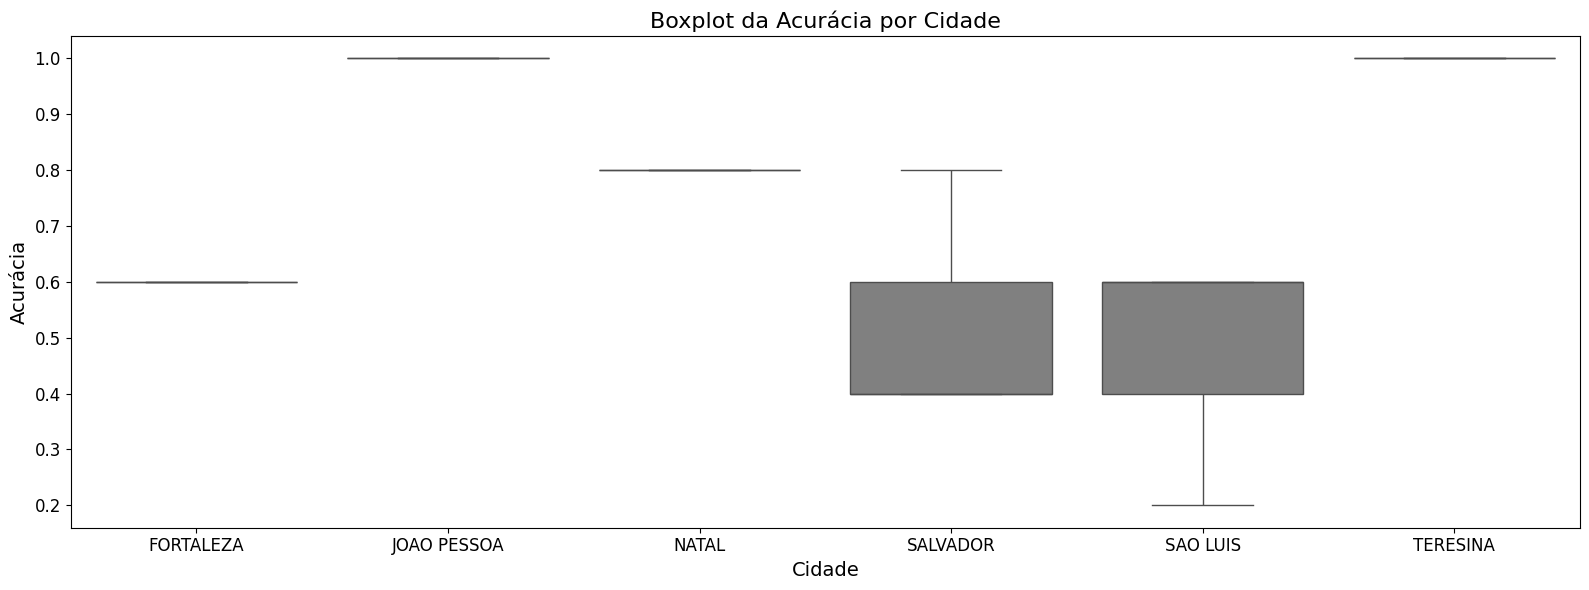

In [67]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Cidade", y="Acurácia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acurácia por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

Ao analisarmos as acurácias por modelo, observamos que a maioria apresenta desempenho semelhante. Os modelos **XGBoost**, **Logistic Regression** e **Random Forest Classifier** tiveram resultados praticamente idênticos, com acurácias variando entre **0.4** e **1.0**.

Por outro lado, o modelo bayesiano desenvolvido com a biblioteca `pgmpy` apresentou o **pior desempenho**, com acurácia chegando a apenas **0.2**, conforme evidenciado no grafo.

O modelo com **melhor desempenho geral** foi o **Support Vector Machine (SVM)**, cuja acurácia teve um limite inferior de **0.6**, indicando resultados mais consistentes mesmo nos piores cenários.

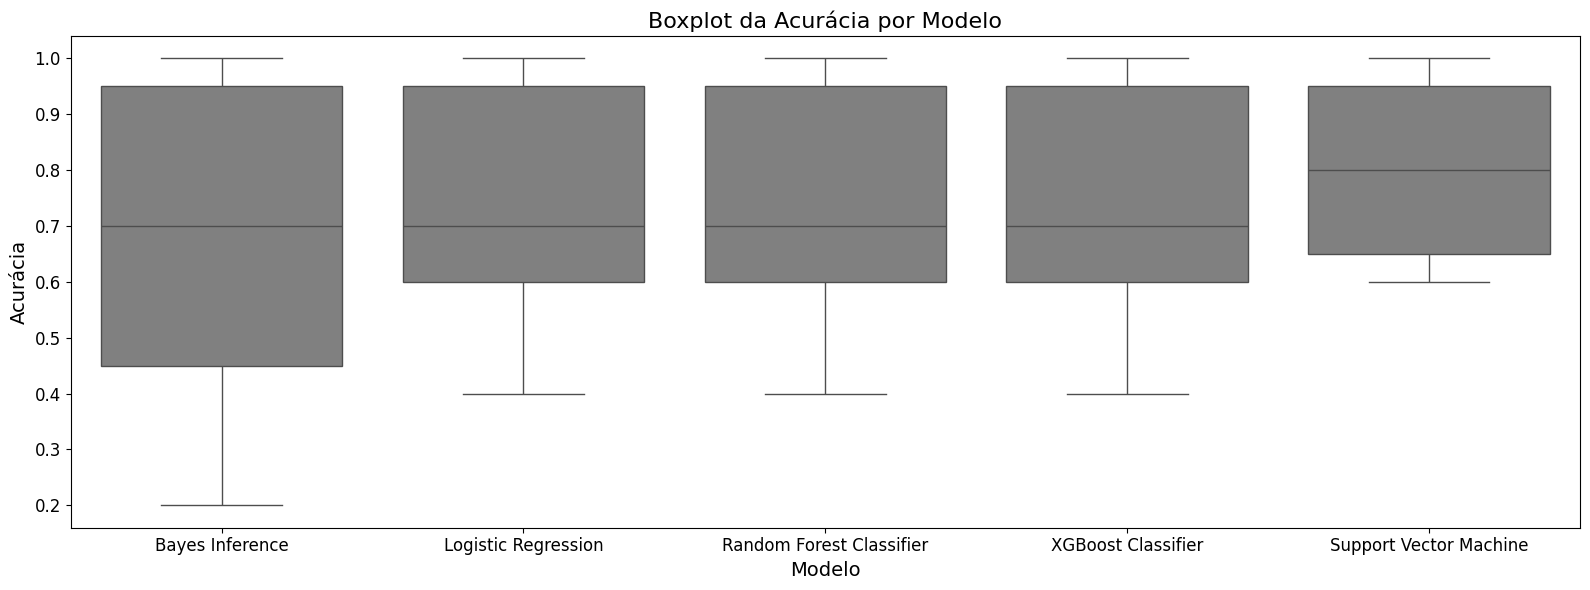

In [68]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Modelo", y="Acurácia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acurácia por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### 3.3.1.2. MAE

Já ao análisarmos a medida MAE para os modelos manualmente definidos temos insight interessantes.

Na avaliação dos modelos por meio da métrica de erro **MAE (Mean Absolute Error)**, observamos que os classificadores **Random Forest** e **Support Vector Machine (SVM)** apresentaram desempenhos *praticamente idênticos*, sugerindo que ambos conseguem capturar padrões nos dados de maneira semelhante, com erros médios equivalentes.

Por outro lado, os modelos **XGBoost** e **Regressão Logística** se destacaram por apresentarem **limites inferiores mais baixos nos boxplots**. Isso indica que, em algumas execuções ou subconjuntos de dados, esses modelos conseguiram alcançar desempenhos melhores que os demais, evidenciando seu potencial para obter previsões mais precisas em certos cenários.

Em contraste, o modelo de inferência probabilística baseado em **pgmpy** (biblioteca para redes bayesianas) apresentou tanto o **menor limite inferior quanto o menor limite superior** no boxplot. Essa baixa dispersão associada a altos valores de erro sugere que o modelo teve **desempenho consistentemente inferior**, com previsões menos precisas de forma geral e pouca variação entre execuções. Isso pode indicar limitações do modelo em capturar a complexidade dos dados ou uma inadequação ao tipo de problema tratado.

Essas análises reforçam a importância de comparar não apenas os valores centrais das métricas, mas também a **distribuição dos erros**, pois oferecem uma visão mais completa sobre a **robustez** e a **consistência** dos modelos em diferentes condições de teste.


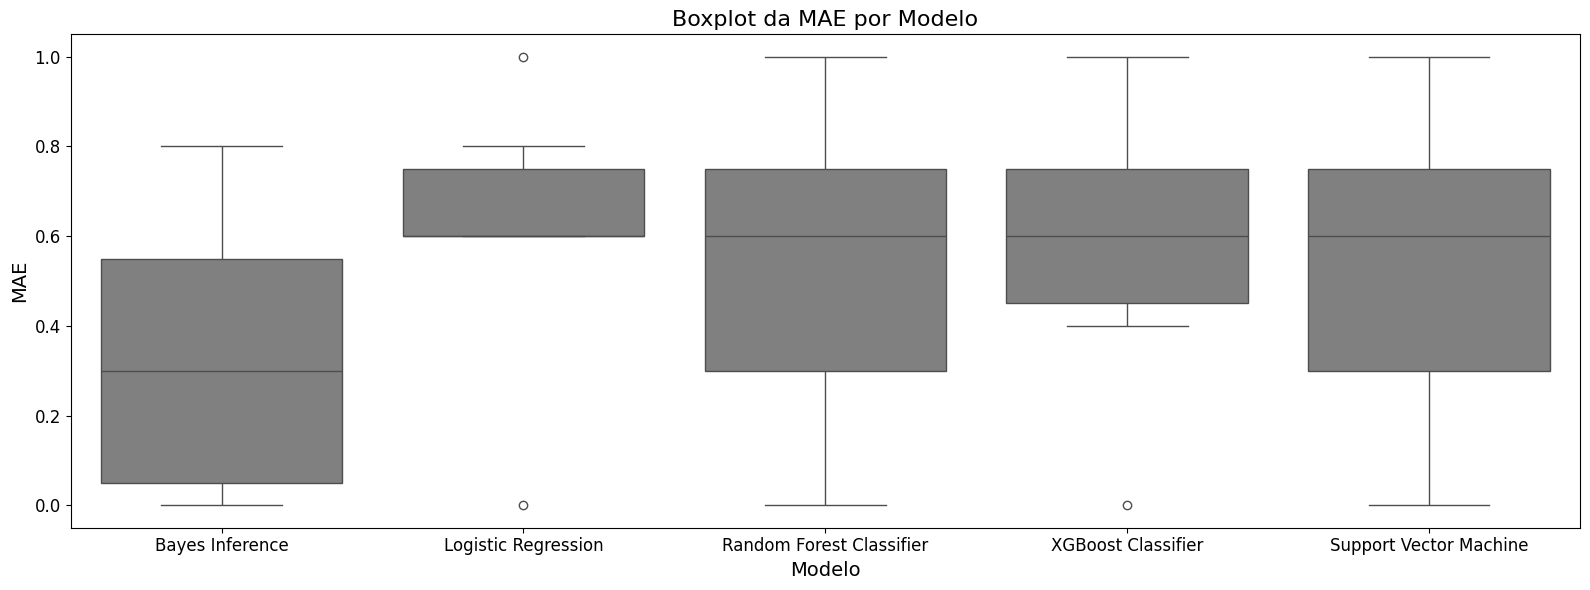

In [ ]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_ManParam, x="Modelo", y="MAE", color='grey')
# Ajustando os textos
plt.title('Boxplot da MAE por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### Geral

Abaixo podemos ver o dataframe geral que contém as informações sobre a cidade o modelo a acurácia e MAE. 

In [69]:
df_combined_ManParam

,Cidade,Modelo,Acurácia,MAE
0,FORTALEZA,Bayes Inference,0.6,0.4
1,JOAO PESSOA,Bayes Inference,1.0,0.0
2,NATAL,Bayes Inference,0.8,0.2
3,SALVADOR,Bayes Inference,0.4,0.6
4,SAO LUIS,Bayes Inference,0.2,0.8
5,TERESINA,Bayes Inference,1.0,0.0
6,FORTALEZA,Logistic Regression,0.6,0.8
7,FORTALEZA,Random Forest Classifier,0.6,0.8
8,FORTALEZA,XGBoost Classifier,0.6,0.8
9,FORTALEZA,Support Vector Machine,0.6,0.8


### 3.3.2. Modelos Otimamente definidos

A seguir veremos as medidas de desempenho para os modelos otimamente definidos.

#### 3.3.2.1 Acurácia

Na análise de acurácia por cidade, observamos que os **modelos com hiperparâmetros otimizados** apresentaram desempenho superior em comparação aos modelos definidos manualmente. Essa melhoria é evidenciada pela **forma mais estreita dos boxplots**, indicando **menor variabilidade nos resultados** e, portanto, maior consistência nas classificações.

Além disso, os **limites inferiores mais baixos** nos boxplots sugerem que os modelos otimizados conseguiram alcançar **maior acurácia mínima**, mesmo nos piores cenários. Isso indica que esses modelos foram mais eficazes na **classificação correta dos dados em diferentes cidades**, apresentando um desempenho mais robusto.

Outro ponto importante é que os modelos otimizados mostraram **desempenhos bastante semelhantes entre si**, o que reforça a ideia de que a otimização contribuiu significativamente para a generalização dos modelos, reduzindo discrepâncias de desempenho entre diferentes algoritmos.

Esses resultados destacam a importância da otimização de hiperparâmetros no processo de modelagem, especialmente quando se busca desempenho consistente em diferentes subconjuntos geográficos dos dados.


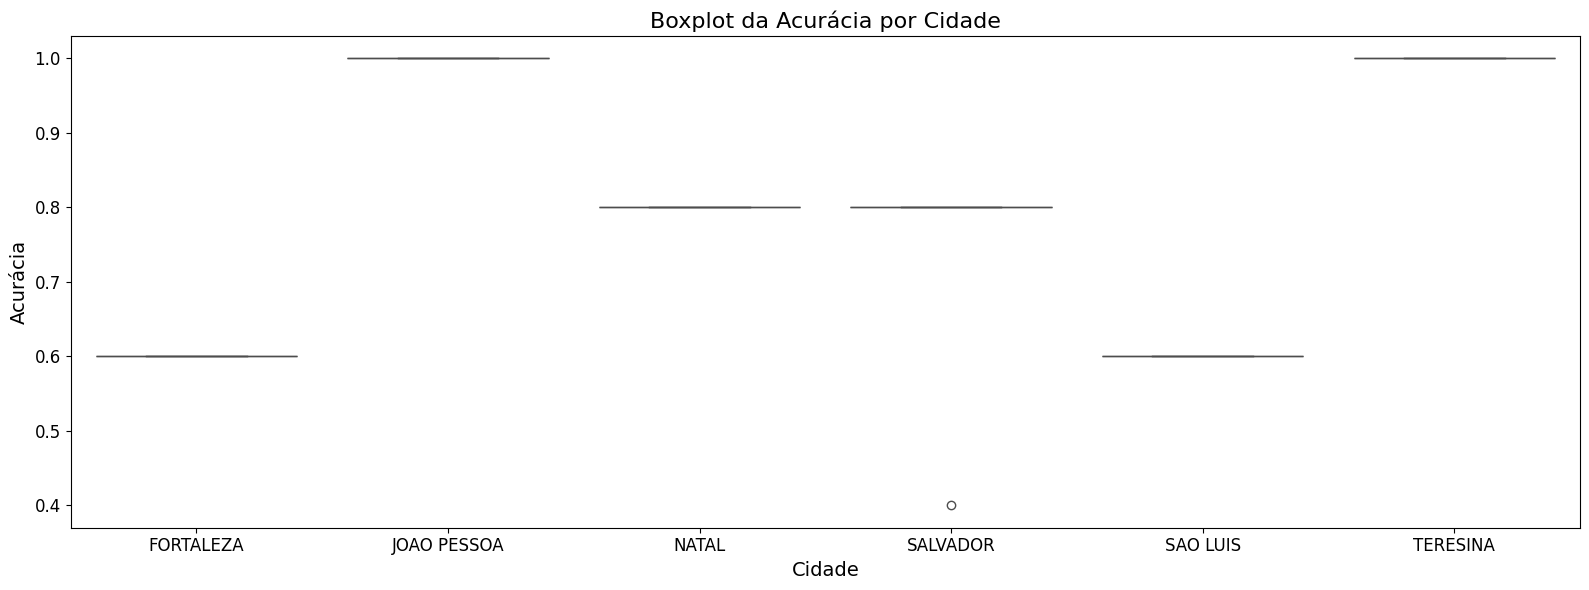

In [70]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Cidade", y="Acurácia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acurácia por Cidade', fontsize=16)
plt.xlabel('Cidade', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

O gráfico apresentado reforça ainda mais a **semelhança de desempenho entre os modelos otimizados**. Com exceção do **modelo Random Forest**, que apresentou uma acurácia ligeiramente inferior, todos os demais modelos obtiveram **resultados praticamente idênticos**, evidenciando uma alta consistência entre eles.

Os modelos otimizados mantiveram **acurácia superior a 0.6 em todas as cidades**, um resultado significativamente melhor quando comparado aos modelos definidos manualmente. Isso demonstra o impacto positivo da otimização de hiperparâmetros na qualidade preditiva dos modelos.

Outro ponto de destaque é o desempenho do **modelo bayesiano**, que anteriormente, entre os modelos manualmente configurados, havia sido o que apresentou pior desempenho. Nesta nova configuração otimizada, seu desempenho se iguala ao dos demais modelos, o que ressalta o **potencial da inferência estatística bayesiana** quando corretamente ajustada.

Esses resultados reforçam a importância de métodos de otimização e mostram que até mesmo modelos que inicialmente pareceram fracos podem alcançar excelente desempenho quando bem calibrados.


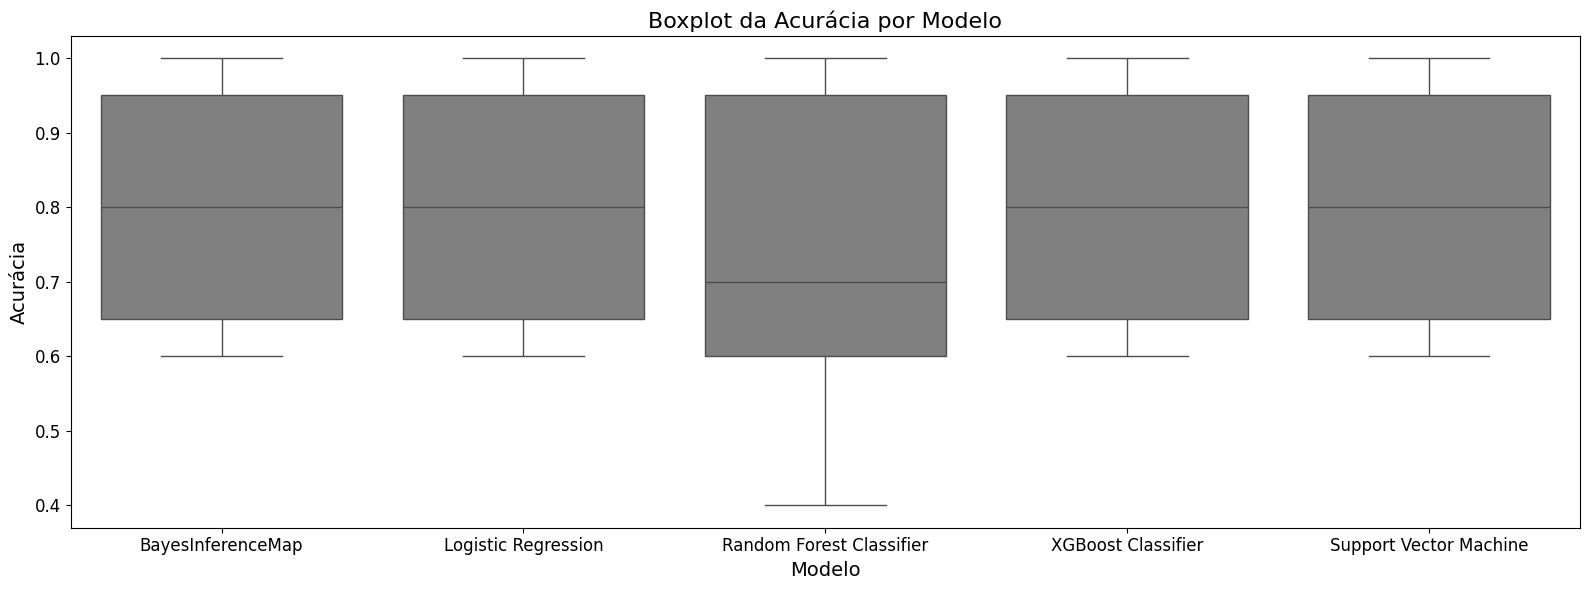

In [71]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Modelo", y="Acurácia", color='grey')
# Ajustando os textos
plt.title('Boxplot da Acurácia por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### 3.3.2.2 MAE

Ao observar o boxplot da **MAE (Mean Absolute Error)** por modelo, percebemos que os **modelos tradicionais da biblioteca scikit-learn** — como Random Forest, SVM, Regressão Logística e XGBoost — apresentaram **desempenhos praticamente idênticos**, com **limites inferior e superior coincidentes**. Essa uniformidade sugere que, apesar das diferenças em suas arquiteturas, esses modelos foram igualmente eficazes na tarefa, com **pouca variação nos erros absolutos**.

Por outro lado, o **modelo bayesiano**, embora tenha apresentado um **valor mínimo (MAP) inferior aos demais** — o que indica que, em certos casos, foi capaz de gerar previsões mais precisas —, mostrou **menos variabilidade nos dados**. Isso é evidenciado pelo fato de que seu **limite superior está muito próximo do terceiro quartil**, e o **limite inferior muito próximo do primeiro quartil**, o que resulta em um **boxplot mais “compacto”**. Além disso, o modelo apresenta **poucos outliers**, o que sugere uma **consistência maior entre as previsões**, mesmo que seu erro médio não tenha sido o menor.

Essa análise indica que o **modelo bayesiano, embora não seja o mais preciso em média, é mais estável** e menos suscetível a grandes erros em diferentes execuções. Essa característica pode ser vantajosa em contextos onde a **confiabilidade e a previsibilidade do erro são mais importantes que a acurácia média máxima**.

Esses resultados reforçam a ideia de que não apenas o valor médio do erro deve ser considerado, mas também a **distribuição e a variabilidade dos erros**, especialmente ao comparar modelos com características estatísticas distintas.


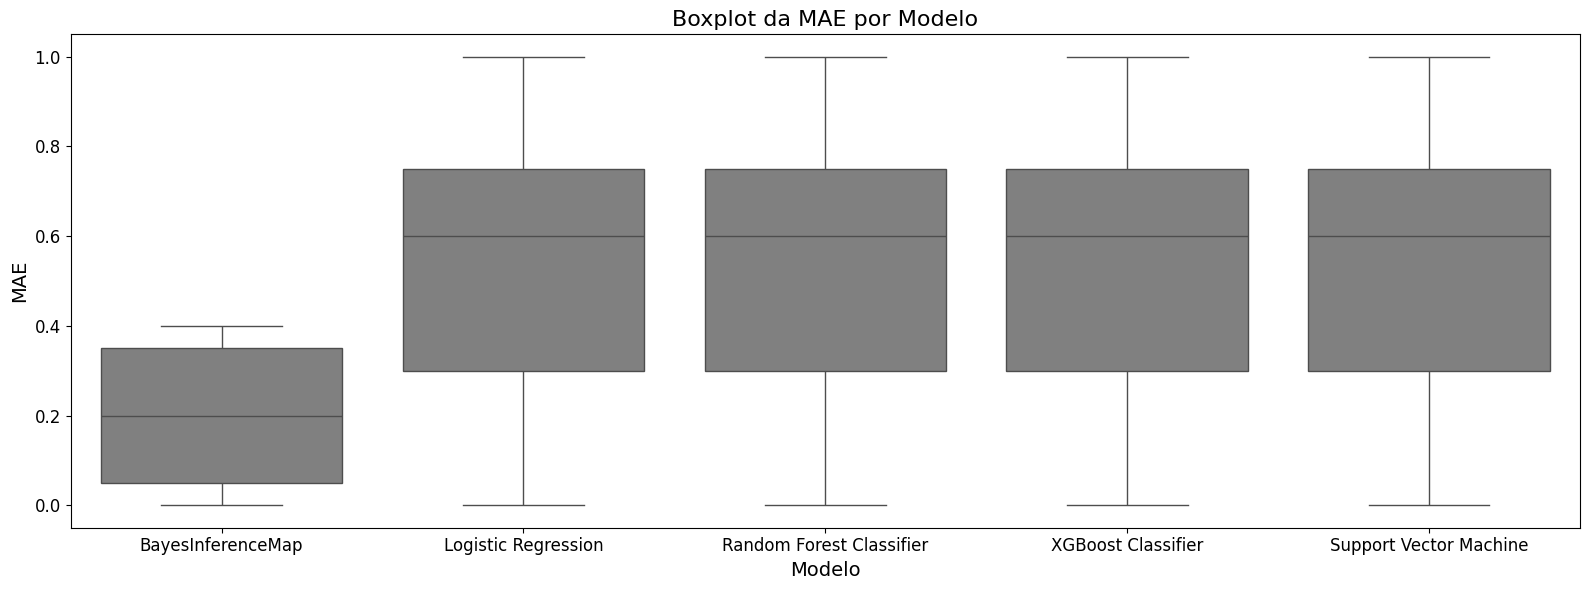

In [73]:
import seaborn as sns
plt.figure(figsize=(16, 6))

# Boxplot
sns.boxplot(data=df_combined_HipParam, x="Modelo", y="MAE", color='grey')
# Ajustando os textos
plt.title('Boxplot da MAE por Modelo', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Ajustar layout
plt.tight_layout()
plt.show()

#### Geral

Abaixo podemos ver o dataframe geral que contém as informações sobre a cidade o modelo a acurácia e MAE. 

In [74]:
df_combined_HipParam

,Cidade,Modelo,Acurácia,MAE
0,FORTALEZA,BayesInferenceMap,0.6,0.4
1,JOAO PESSOA,BayesInferenceMap,1.0,0.0
2,NATAL,BayesInferenceMap,0.8,0.2
3,SALVADOR,BayesInferenceMap,0.8,0.2
4,SAO LUIS,BayesInferenceMap,0.6,0.4
5,TERESINA,BayesInferenceMap,1.0,0.0
6,FORTALEZA,Logistic Regression,0.6,0.8
7,FORTALEZA,Random Forest Classifier,0.6,0.8
8,FORTALEZA,XGBoost Classifier,0.6,0.8
9,FORTALEZA,Support Vector Machine,0.6,0.8
